Kelompok 7 2023A
1.   Iqbal Syandana Arkan (23031554079)
2.   Kevin Davindio Atha  (23031554173)
3.   Kharisma Adhi Wibowo (23031554175)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Library

In [3]:
import os
import glob
import warnings
warnings.filterwarnings("ignore")

# Image Processing
import cv2
from PIL import Image

# Data Handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Machine Learning , Model Training, Evaluation, and Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Save Model
import joblib

## Load Data

In [ ]:
dataset_train = pd.read_csv("/content/drive/MyDrive/projek_semester_4/PCD/sign_data/train_data.csv",header=None, names=['gambar1', 'gambar2', 'target'])
dataset_test = pd.read_csv("/content/drive/MyDrive/projek_semester_4/PCD/sign_data/test_data.csv",header=None, names=['gambar1', 'gambar2', 'target'])
dir_train = "/content/drive/MyDrive/projek_semester_4/PCD/sign_data/train"
dir_test = "/content/drive/MyDrive/projek_semester_4/PCD/sign_data/test"

In [ ]:
dataset_train.head(10)

,gambar1,gambar2,target
0,068/09_068.png,068_forg/03_0113068.PNG,1
1,068/09_068.png,068_forg/01_0124068.PNG,1
2,068/09_068.png,068_forg/02_0124068.PNG,1
3,068/09_068.png,068_forg/01_0113068.PNG,1
4,068/09_068.png,068_forg/04_0124068.PNG,1
5,068/09_068.png,068_forg/04_0113068.PNG,1
6,068/09_068.png,068_forg/02_0113068.PNG,1
7,068/09_068.png,068_forg/03_0124068.PNG,1
8,068/02_068.png,068_forg/03_0113068.PNG,1
9,068/02_068.png,068_forg/01_0124068.PNG,1


In [ ]:
print(len(dataset_train), len(dataset_test))

23206 5748


In [ ]:
# Rentang folder yang diinginkan (batas awal sampai batas akhir)
batas_awal = 47
batas_akhir = 69
selected_folders = [f"{i:03d}" for i in range(batas_awal, batas_akhir+1)] + [f"{i:03d}_forg" for i in range(batas_awal, batas_akhir+1)]
folder_gambar_asli = selected_folders[:23]
folder_gambar_palsu = selected_folders[23:]

# Loop untuk mengambil path semua gambar dalam folder yang diinginkan
def get_image_paths(folder_gambar):
  image_paths = []
  for folder in folder_gambar:
      folder_path = os.path.join(dir_train, folder)
      if os.path.exists(folder_path):
          image_paths.extend(glob.glob(os.path.join(folder_path, '*.*')))
  return image_paths

image_paths_asli = get_image_paths(folder_gambar_asli)
image_paths_palsu = get_image_paths(folder_gambar_palsu)

In [ ]:
print(len(image_paths_asli), len(image_paths_palsu))

276 268


In [ ]:
image_path_asli_for_features = [image_paths_asli[i][65:] for i in range(len(image_paths_asli))]
image_path_asli_for_features[:5]

['02_047.png', '05_047.png', '11_047.png', '04_047.png', '01_047.png']

In [ ]:
image_path_palsu_for_features = [image_paths_palsu[i][70:] for i in range(len(image_paths_palsu))]
image_path_palsu_for_features[:5]

['01_0113047.PNG',
 '02_0114047.PNG',
 '04_0212047.PNG',
 '01_0114047.PNG',
 '03_0114047.PNG']

## Preprocessing

### Grayscale

In [ ]:
def grayscale(image_paths,keterangan):
    image_grayscale = [img for path in image_paths if (img := cv2.imread(path, cv2.IMREAD_GRAYSCALE)) is not None]
    originals_images = [cv2.imread(path) for path in image_paths[:3]]
    visualize_grayscale(originals_images, image_grayscale[:3],keterangan)
    return image_grayscale

def visualize_grayscale(originals,grayscale,keterangan):
    num_images = len(grayscale)
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 4, 6))
    fig.subplots_adjust(hspace=0.5, top=0.85, bottom=0.1)

    for i, image_path in enumerate(grayscale):
        # gambar sebelum grayscale
        axes[0, i].imshow(cv2.cvtColor(originals[i], cv2.COLOR_BGR2RGB))
        if keterangan =="asli":
          axes[0, i].set_title(f"{image_paths_asli[i][-14:]}")
        else:
          axes[0, i].set_title(f"{image_paths_palsu[i][-23:]}")
        axes[0, i].axis("off")

        # gambar setelah grayscale
        axes[1, i].imshow(grayscale[i], cmap='gray')
        if keterangan =="asli":
          axes[1, i].set_title(f"{image_paths_asli[i][-14:]}")
        else:
          axes[1, i].set_title(f"{image_paths_palsu[i][-23:]}")
        axes[1, i].axis("off")
    fig.text(0.5, 0.95, 'Gambar Sebelum Graysacle', ha='center', fontsize=16, weight='bold')
    fig.text(0.5, 0.48, 'Gambar Setelah Grayscale', ha='center', fontsize=16, weight='bold')

    plt.show()

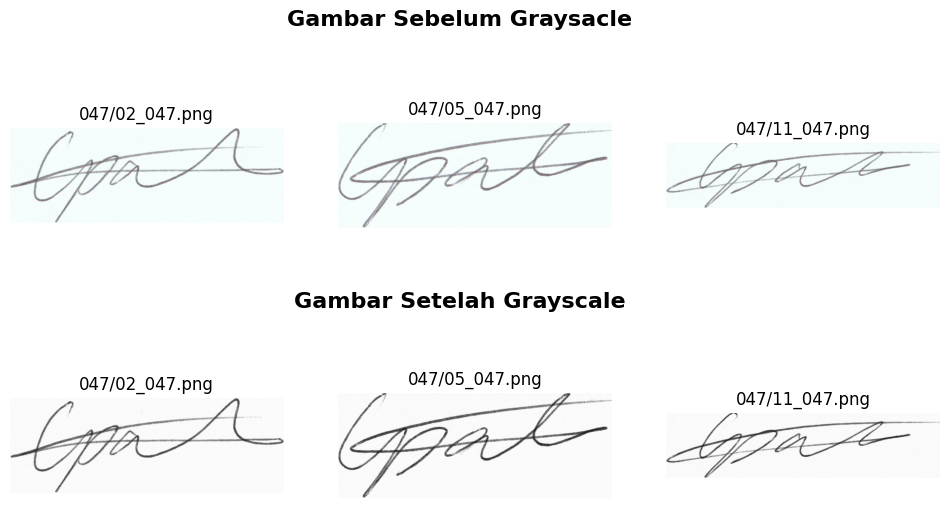

In [ ]:
image_paths_asli_grayscale = grayscale(image_paths_asli,"asli")

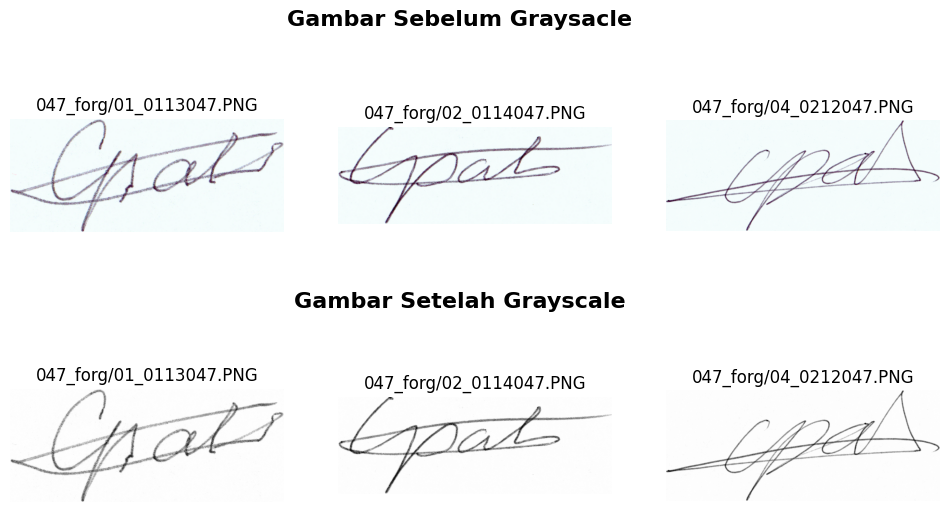

In [ ]:
image_paths_palsu_grayscale = grayscale(image_paths_palsu,"palsu")

### Remove Noise

In [ ]:
def remove_noise_and_visualize(image_data, keterangan, method="gaussian", ksize=3):
    cleaned_images = []
    for img in image_data:
        if method == "median":
            denoised = cv2.medianBlur(img, ksize)
        elif method == "gaussian":
            denoised = cv2.GaussianBlur(img, (ksize, ksize), 0)
        else:
            raise ValueError("Method tidak dikenal. Gunakan 'median' atau 'gaussian'")
        cleaned_images.append(denoised)
    visualize_before_after(image_data[:3], cleaned_images[:3],keterangan)

    return cleaned_images

def visualize_before_after(before_cleaned,cleaned,keterangan):
    num_images = len(before_cleaned)
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 4, 6))
    fig.subplots_adjust(hspace=0.5, top=0.85, bottom=0.1)

    for i, image_path in enumerate(before_cleaned):
        # gambar sebelum denoising
        axes[0, i].imshow(cv2.cvtColor(before_cleaned[i], cv2.COLOR_BGR2RGB))
        if keterangan =="asli":
          axes[0, i].set_title(f"{image_paths_asli[i][-14:]}")
        else:
          axes[0, i].set_title(f"{image_paths_palsu[i][-23:]}")
        axes[0, i].axis("off")

        # gambar setelah denoising
        axes[1, i].imshow(cleaned[i], cmap='gray')
        if keterangan =="asli":
          axes[1, i].set_title(f"{image_paths_asli[i][-14:]}")
        else:
          axes[1, i].set_title(f"{image_paths_palsu[i][-23:]}")
        axes[1, i].axis("off")

    fig.text(0.5, 0.95, 'Gambar Sebelum Denoising', ha='center', fontsize=16, weight='bold')
    fig.text(0.5, 0.48, 'Gambar Setelah Denoising', ha='center', fontsize=16, weight='bold')

    plt.show()

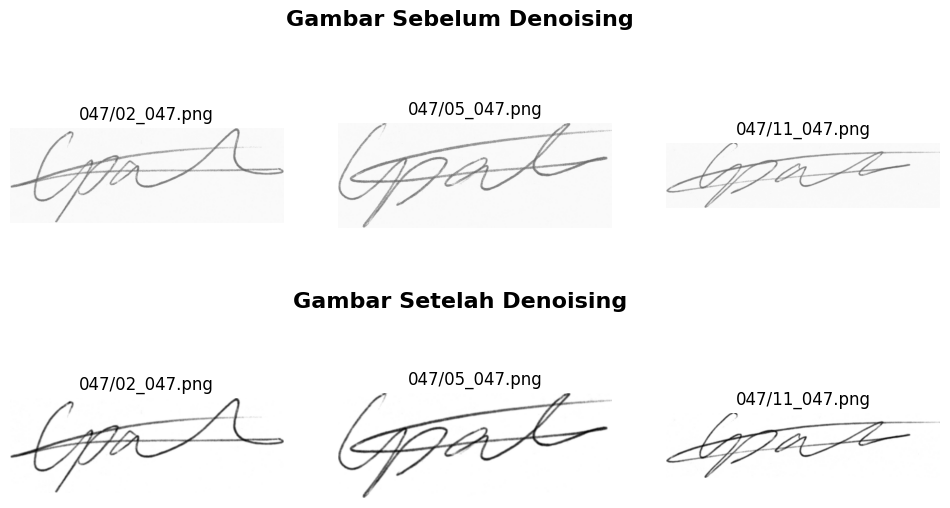

In [ ]:
image_paths_asli_clean = remove_noise_and_visualize(image_paths_asli_grayscale, "asli", method="gaussian", ksize=5)

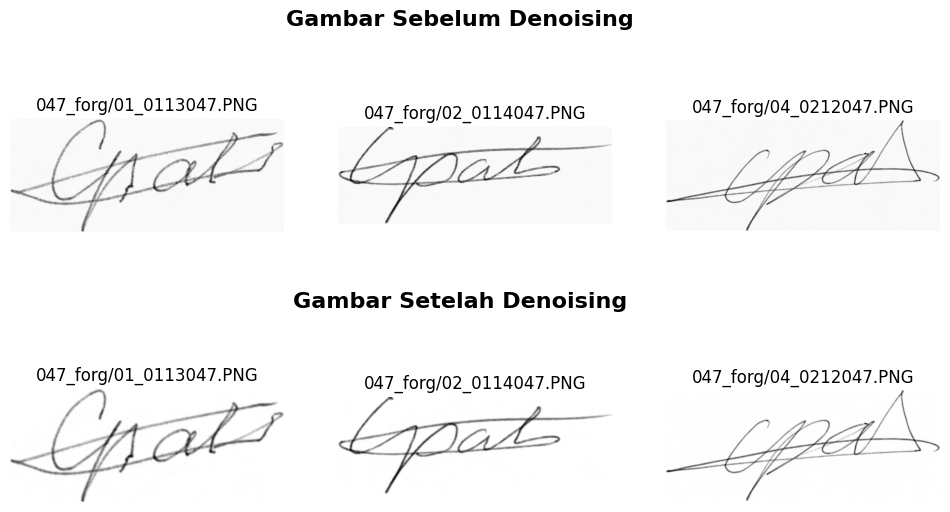

In [ ]:
image_paths_palsu_clean = remove_noise_and_visualize(image_paths_palsu_grayscale, "plasu", method="gaussian", ksize=5)

### Threshold

In [ ]:
def apply_threshold(cleaned_images,keterangan):
    binary_images = []
    for img in cleaned_images:
        _, binary_otsu = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        binary_images.append(binary_otsu)

    visualize_thresholding(cleaned_images[:3], binary_images[:3],keterangan)

    return binary_images

def visualize_thresholding(before_thresholding,thresholding,keterangan):
    num_images = len(before_thresholding)
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 4, 6))
    fig.subplots_adjust(hspace=0.5, top=0.85, bottom=0.1)

    for i, image_path in enumerate(before_thresholding):
        # gambar sebelum threshold
        axes[0, i].imshow(cv2.cvtColor(before_thresholding[i], cv2.COLOR_BGR2RGB))
        if keterangan =="asli":
          axes[0, i].set_title(f"{image_paths_asli[i][-14:]}")
        else:
          axes[0, i].set_title(f"{image_paths_palsu[i][-23:]}")
        axes[0, i].axis("off")

        # gambar setelah threshold
        axes[1, i].imshow(thresholding[i], cmap='gray')
        if keterangan =="asli":
          axes[1, i].set_title(f"{image_paths_asli[i][-14:]}")
        else:
          axes[1, i].set_title(f"{image_paths_palsu[i][-23:]}")
        axes[1, i].axis("off")

    fig.text(0.5, 0.95, 'Gambar Sebelum thresholding', ha='center', fontsize=16, weight='bold') #Update the title
    fig.text(0.5, 0.48, 'Gambar Setelah thresholding', ha='center', fontsize=16, weight='bold') #Update the title

    plt.show()

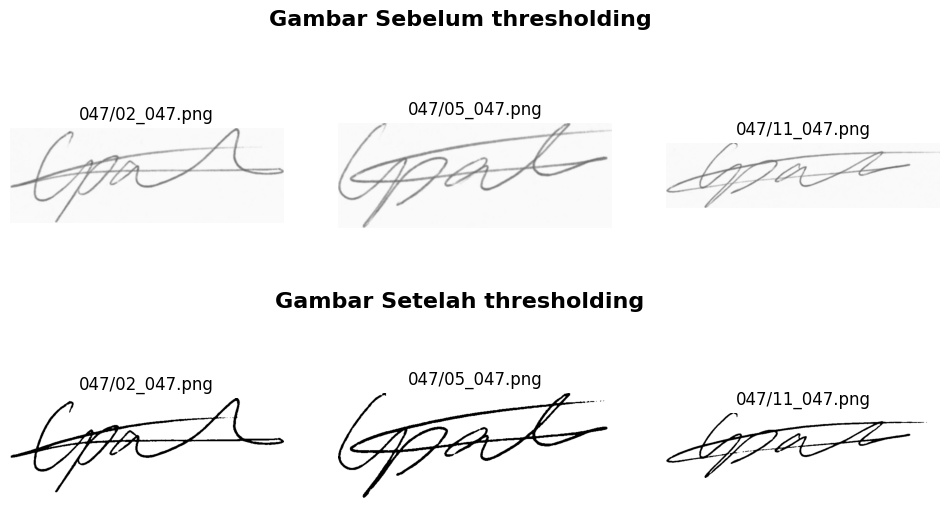

In [ ]:
image_paths_asli_threshold = apply_threshold(image_paths_asli_clean,"asli")

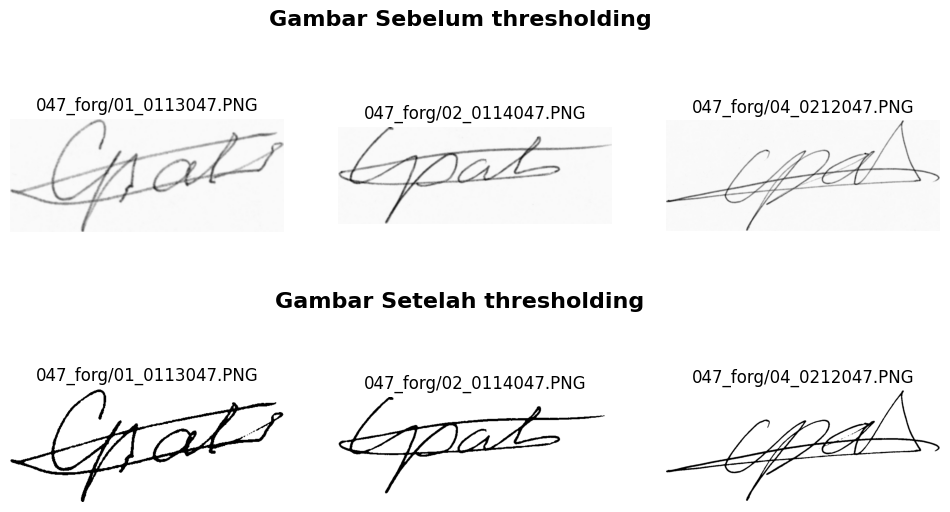

In [ ]:
image_paths_palsu_threshold = apply_threshold(image_paths_palsu_clean,"palsu")

### Opening

In [ ]:
def apply_morphology(binary_images,keterangan, operation='closing', kernel_size=(3,3)):
    processed_images = []
    for image in binary_images:
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
        if operation == 'opening':
            processed = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
        elif operation == 'closing':
            processed = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
        else:
            raise ValueError("Operation harus 'opening' atau 'closing'")
        processed_images.append(processed)

    visualize_morphology(binary_images[:3], processed_images[:3],keterangan)

    return processed_images

def visualize_morphology(before_morphology,morphology,keterangan):
    num_images = len(before_morphology)
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 4, 6))
    fig.subplots_adjust(hspace=0.5, top=0.85, bottom=0.1)

    for i, image_path in enumerate(before_morphology):
        # gambar sebelum closing
        axes[0, i].imshow(cv2.cvtColor(before_morphology[i], cv2.COLOR_BGR2RGB))
        if keterangan =="asli":
          axes[0, i].set_title(f"{image_paths_asli[i][-14:]}")
        else:
          axes[0, i].set_title(f"{image_paths_palsu[i][-23:]}")
        axes[0, i].axis("off")

        # gambar setelah closing
        axes[1, i].imshow(morphology[i], cmap='gray')
        if keterangan =="asli":
          axes[1, i].set_title(f"{image_paths_asli[i][-14:]}")
        else:
          axes[1, i].set_title(f"{image_paths_palsu[i][-23:]}")
        axes[1, i].axis("off")

    fig.text(0.5, 0.95, 'Gambar Sebelum morphology', ha='center', fontsize=16, weight='bold')
    fig.text(0.5, 0.48, 'Gambar Setelah morphology', ha='center', fontsize=16, weight='bold')

    plt.show()

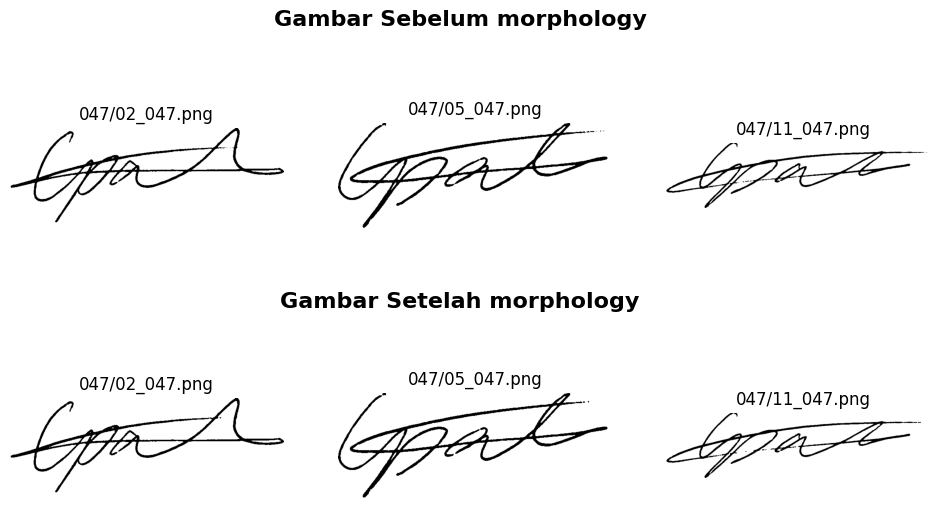

In [ ]:
image_paths_asli_morphology = apply_morphology(image_paths_asli_threshold,"asli")

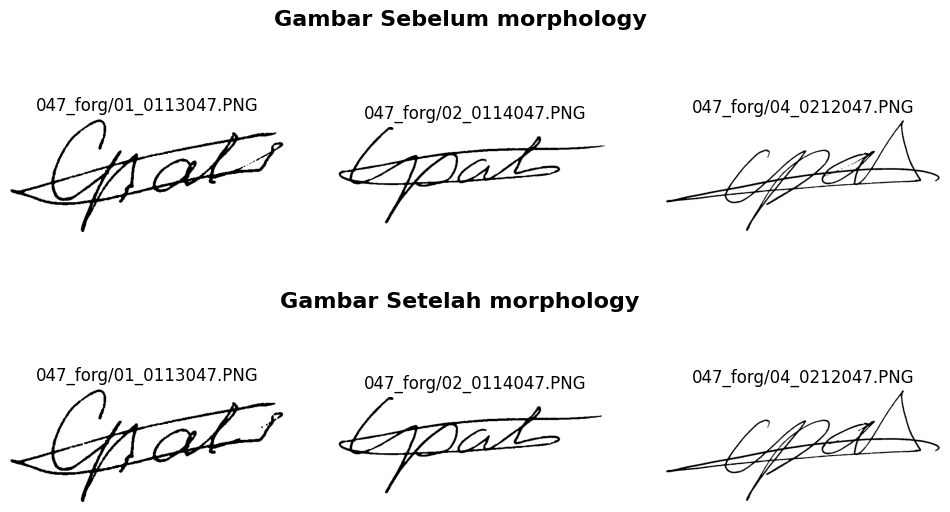

In [ ]:
image_paths_palsu_morphology = apply_morphology(image_paths_palsu_threshold,"palsu")

### Resize

In [ ]:
def resize_signature(processed_images,keterangan, target_size=(497, 126)):
    resized_images = [cv2.resize(image, target_size, interpolation=cv2.INTER_AREA) for image in processed_images]
    visualize_resize(processed_images[:5], resized_images[:5],keterangan)

    return resized_images

def visualize_resize(before_resize,resize,keterangan):
    num_images = len(before_resize)
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 4, 6))
    fig.subplots_adjust(hspace=0.5, top=0.85, bottom=0.1)
    fig.patch.set_facecolor('black')

    for i, image_path in enumerate(before_resize):
        # gambar sebelum resize
        axes[0, i].imshow(cv2.cvtColor(before_resize[i], cv2.COLOR_BGR2RGB))
        if keterangan =="asli":
          axes[0, i].set_title(f"{image_paths_asli[i][-14:]}",color='white')
        else:
          axes[0, i].set_title(f"{image_paths_palsu[i][-23:]}",color='white')
        axes[0, i].axis("off")

        # gambar setelah resize
        axes[1, i].imshow(resize[i], cmap='gray')
        if keterangan =="asli":
          axes[1, i].set_title(f"{image_paths_asli[i][-14:]}",color='white')
        else:
          axes[1, i].set_title(f"{image_paths_palsu[i][-23:]}",color='white')
        axes[1, i].axis("off")

    fig.text(0.5, 0.95, 'Gambar Sebelum resize', ha='center', fontsize=16, weight='bold',color='white')
    fig.text(0.5, 0.48, 'Gambar Setelah resize', ha='center', fontsize=16, weight='bold',color='white')

    plt.show()

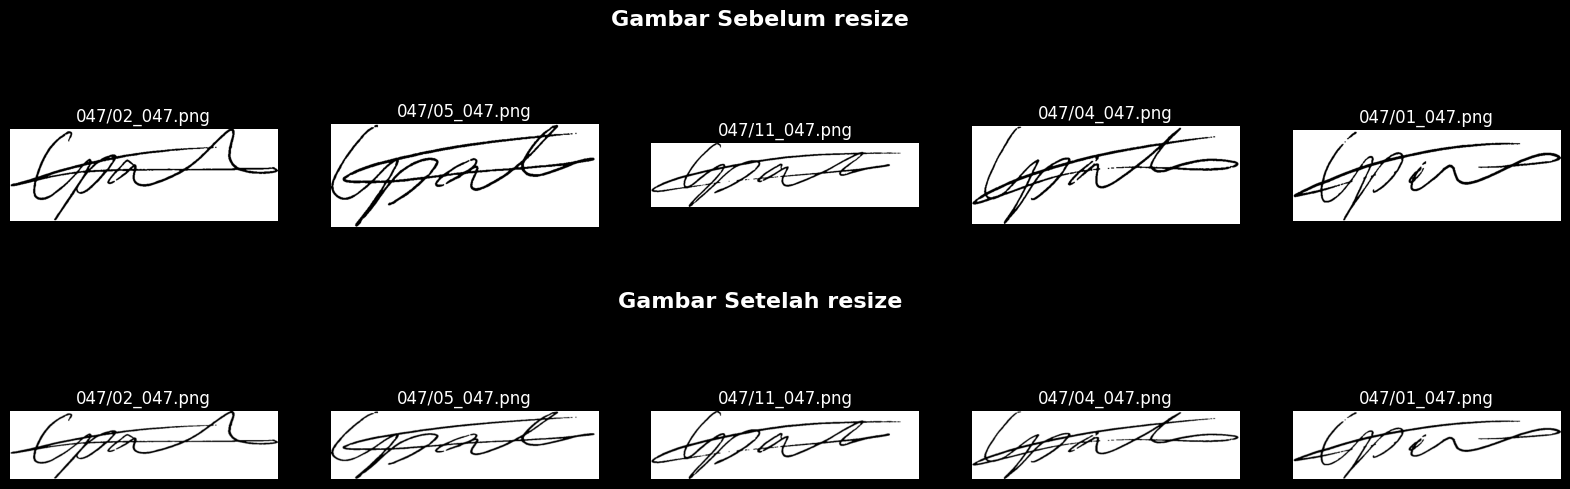

In [ ]:
image_paths_asli_resize = resize_signature(image_paths_asli_morphology,"asli")

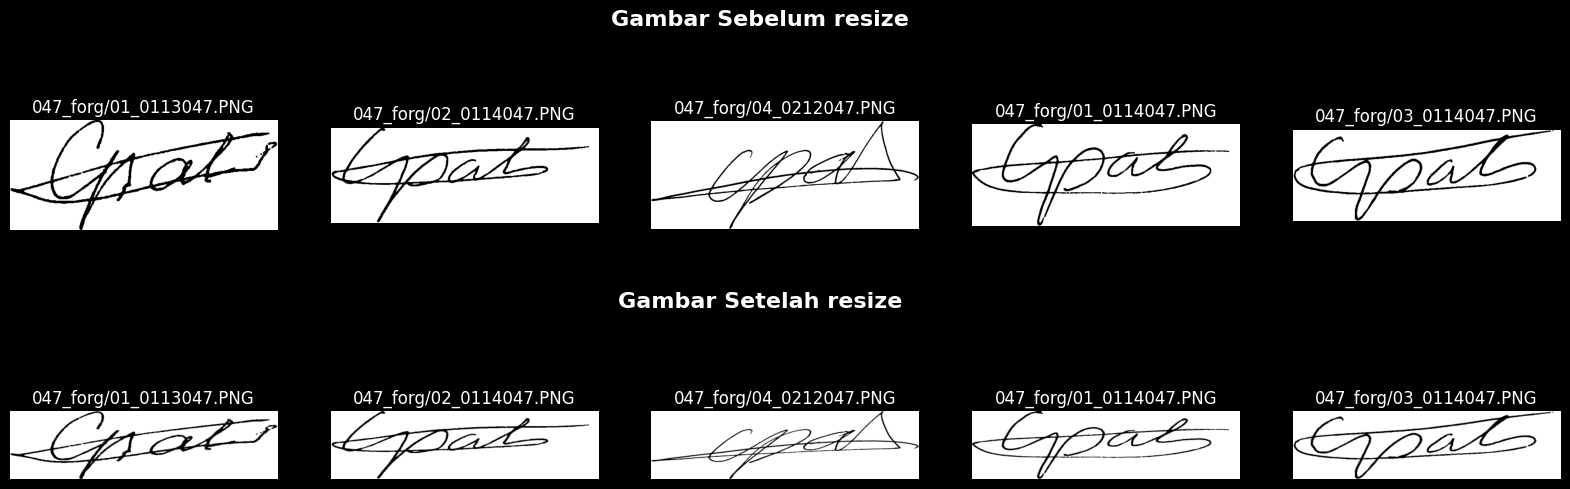

In [ ]:
image_paths_palsu_resize = resize_signature(image_paths_palsu_morphology,"palsu")

### Save image hasil resize

In [ ]:
image_path_asli_for_features = [image_paths_asli[i][65:] for i in range(len(image_paths_asli))]
image_path_palsu_for_features = [image_paths_palsu[i][70:] for i in range(len(image_paths_palsu))]

In [ ]:
image_path_asli_for_features[:5]

['02_047.png', '05_047.png', '11_047.png', '04_047.png', '01_047.png']

In [ ]:
image_path_palsu_for_features[:5]

['01_0113047.PNG',
 '02_0114047.PNG',
 '04_0212047.PNG',
 '01_0114047.PNG',
 '03_0114047.PNG']

In [ ]:
def save_resized_images_with_structure(resized_images, nama_paths, save_root_dir):
    for img, nama_path in zip(resized_images, nama_paths):
        save_path = os.path.join(save_root_dir, nama_path)
        folder_path = os.path.dirname(save_path)

        if folder_path:
            os.makedirs(folder_path, exist_ok=True)

        cv2.imwrite(save_path, img)
        print(f"Gambar disimpan di: {save_path}")

save_resized_images_with_structure(
    image_paths_asli_resize,
    image_path_asli_for_features,
    "/content/drive/MyDrive/projek_semester_4/PCD/resize_new"
)

save_resized_images_with_structure(
    image_paths_palsu_resize,
    image_path_palsu_for_features,
    "/content/drive/MyDrive/projek_semester_4/PCD/resize_new"
)

Gambar disimpan di: /content/drive/MyDrive/projek_semester_4/PCD/resize_new/02_047.png
Gambar disimpan di: /content/drive/MyDrive/projek_semester_4/PCD/resize_new/05_047.png
Gambar disimpan di: /content/drive/MyDrive/projek_semester_4/PCD/resize_new/11_047.png
Gambar disimpan di: /content/drive/MyDrive/projek_semester_4/PCD/resize_new/04_047.png
Gambar disimpan di: /content/drive/MyDrive/projek_semester_4/PCD/resize_new/01_047.png
Gambar disimpan di: /content/drive/MyDrive/projek_semester_4/PCD/resize_new/07_047.png
Gambar disimpan di: /content/drive/MyDrive/projek_semester_4/PCD/resize_new/10_047.png
Gambar disimpan di: /content/drive/MyDrive/projek_semester_4/PCD/resize_new/12_047.png
Gambar disimpan di: /content/drive/MyDrive/projek_semester_4/PCD/resize_new/08_047.png
Gambar disimpan di: /content/drive/MyDrive/projek_semester_4/PCD/resize_new/06_047.png
Gambar disimpan di: /content/drive/MyDrive/projek_semester_4/PCD/resize_new/09_047.png
Gambar disimpan di: /content/drive/MyDrive/

### Ekstraksi fitur SIFT

In [ ]:
dataset = dataset_train.copy()
dataset.tail()

,gambar1,gambar2,target
23201,031/02_031.png,031/03_031.png,0
23202,031/02_031.png,031/12_031.png,0
23203,031/02_031.png,031/11_031.png,0
23204,031/02_031.png,031/06_031.png,0
23205,031/02_031.png,031/07_031.png,0


In [ ]:
len(dataset)

23206

Karena jumlah data train yang cukup besar yaitu berjumlah 20885, maka dari keseluruhan data akan dibagi menjadi 6 bagian. Jadi ada 6 kali proses running code.

In [ ]:
batas_awal = 19335
# batas_akhir = +1
data_features = dataset.iloc[batas_awal:]
data_features['gambar1'] = data_features['gambar1'].apply(lambda x: x.split('/')[-1])
data_features['gambar2'] = data_features['gambar2'].apply(lambda x: x.split('/')[-1])
data_features.head()

,gambar1,gambar2,target
19335,09_034.png,04_0120034.PNG,1
19336,09_034.png,02_0120034.PNG,1
19337,09_034.png,02_0103034.PNG,1
19338,09_034.png,03_0110034.PNG,1
19339,09_034.png,01_0110034.PNG,1


In [ ]:
data_features.tail()

,gambar1,gambar2,target
23201,02_031.png,03_031.png,0
23202,02_031.png,12_031.png,0
23203,02_031.png,11_031.png,0
23204,02_031.png,06_031.png,0
23205,02_031.png,07_031.png,0


In [ ]:
# Fungsi ekstraksi fitur SIFT dua gambar
def extract_features(img1, img2):
    img1 = cv2.imread(f"/content/drive/MyDrive/projek_semester_4/PCD/resize_new/{img1}", cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread(f"/content/drive/MyDrive/projek_semester_4/PCD/resize_new/{img2}", cv2.IMREAD_GRAYSCALE)
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    if des1 is None or des2 is None:
        return [0, 9999, 0]

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)

    jumlah_match = len(good)
    rata_jarak = np.mean([m.distance for m in good]) if good else 9999
    std_jarak = np.std([m.distance for m in good]) if good else 0
    median_jarak = np.median([m.distance for m in good]) if good else 9999
    rasio = jumlah_match / min(len(des1), len(des2))
    rasio_kp1 = jumlah_match / len(des1)
    rasio_kp2 = jumlah_match / len(des2)
    jumlah_kp1 = len(kp1)
    jumlah_kp2 = len(kp2)
    total_match = len(matches)
    min_jarak = np.min([m.distance for m in good]) if good else 9999
    max_jarak = np.max([m.distance for m in good]) if good else 9999
    rasio_match_total_kp = jumlah_match / (jumlah_kp1 + jumlah_kp2) if (jumlah_kp1 + jumlah_kp2) != 0 else 0
    total_keypoints = jumlah_kp1 + jumlah_kp2
    persentase_good_match = jumlah_match / total_match if total_match != 0 else 0

    return [
        jumlah_match, rata_jarak, rasio, std_jarak, median_jarak, rasio_kp1, rasio_kp2,
        jumlah_kp1, jumlah_kp2, total_match, min_jarak, max_jarak, rasio_match_total_kp,
        total_keypoints, persentase_good_match
    ]

In [ ]:
data_features[['jumlah_match', 'rata_jarak', 'rasio', 'std_jarak', 'median_jarak', 'rasio_kp1', 'rasio_kp2','jumlah_kp1', 'jumlah_kp2', 'total_match','min_jarak', 'max_jarak', 'rasio_match_total_kp','total_keypoints', 'persentase_good_match']] = data_features.apply(
    lambda row: extract_features(row['gambar1'], row['gambar2']),
    axis=1,
    result_type='expand'
)

In [ ]:
hasil = data_features[['jumlah_match', 'rata_jarak', 'rasio', 'std_jarak', 'median_jarak', 'rasio_kp1', 'rasio_kp2','jumlah_kp1', 'jumlah_kp2', 'total_match','min_jarak', 'max_jarak', 'rasio_match_total_kp','total_keypoints', 'persentase_good_match','target']]

# simpan fitur SIFT ke CSV
output_csv = f"/content/drive/MyDrive/projek_semester_4/PCD/data_features/sift_features6_new.csv"
hasil.to_csv(output_csv, index=False)

print(f"Fitur SIFT berhasil disimpan ke: {output_csv}")

Fitur SIFT berhasil disimpan ke: /content/drive/MyDrive/projek_semester_4/PCD/data_features/sift_features6_new.csv


In [ ]:
# Baca semua file CSV
df1 = pd.read_csv("/content/drive/MyDrive/projek_semester_4/PCD/data_features/sift_features1_new.csv")
df2 = pd.read_csv("/content/drive/MyDrive/projek_semester_4/PCD/data_features/sift_features2_new.csv")
df3 = pd.read_csv("/content/drive/MyDrive/projek_semester_4/PCD/data_features/sift_features3_new.csv")
df4 = pd.read_csv("/content/drive/MyDrive/projek_semester_4/PCD/data_features/sift_features4_new.csv")
df5 = pd.read_csv("/content/drive/MyDrive/projek_semester_4/PCD/data_features/sift_features5_new.csv")
df6 = pd.read_csv("/content/drive/MyDrive/projek_semester_4/PCD/data_features/sift_features6_new.csv")

# Gabungkan semua DataFrame jadi satu
gabungan = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index=True)

# Simpan ke file CSV baru
gabungan.to_csv("/content/drive/MyDrive/projek_semester_4/PCD/data_features/data_gabungan_new.csv", index=False)

In [ ]:
gabungan.head()

,jumlah_match,rata_jarak,rasio,std_jarak,median_jarak,rasio_kp1,rasio_kp2,jumlah_kp1,jumlah_kp2,total_match,min_jarak,max_jarak,rasio_match_total_kp,total_keypoints,persentase_good_match,target
0,21.0,171.912552,0.084677,48.833324,180.249832,0.084677,0.063063,248.0,333.0,248.0,75.736382,259.061768,0.036145,581.0,0.084677,1
1,25.0,174.046508,0.100806,54.187569,173.991379,0.100806,0.062500,248.0,400.0,248.0,71.916618,284.142578,0.038580,648.0,0.100806,1
2,16.0,177.316650,0.064516,66.354586,163.403839,0.064516,0.037037,248.0,432.0,248.0,93.984039,318.125763,0.023529,680.0,0.064516,1
3,10.0,155.549760,0.040323,54.941527,139.570435,0.040323,0.025189,248.0,397.0,248.0,88.011360,283.439575,0.015504,645.0,0.040323,1
4,12.0,172.835435,0.048387,58.667813,157.925354,0.048387,0.026374,248.0,455.0,248.0,85.211502,282.690643,0.017070,703.0,0.048387,1


## Model

### KNN

In [ ]:
# Load data
df = pd.read_csv('/content/drive/MyDrive/projek_semester_4/PCD/data_features/data_gabungan_new.csv')
X = df.drop(columns=['target'])
y = df['target']

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Parameter grid
param_grid = {
    'n_neighbors': list(range(1, 50)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
    'p': [1, 2, 3]
}

# KNN dan GridSearch
knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Hasil
print("Best Parameters:", grid_search.best_params_)
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_val)

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

print(f"\nValidation Accuracy: {accuracy_score(y_val, y_pred):.4f}")

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 24, 'p': 1, 'weights': 'distance'}
Best Cross-Validation Accuracy: 0.6832

Confusion Matrix:
[[1974  547]
 [ 876 1245]]

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.78      0.74      2521
           1       0.69      0.59      0.64      2121

    accuracy                           0.69      4642
   macro avg       0.69      0.69      0.69      4642
weighted avg       0.69      0.69      0.69      4642


Validation Accuracy: 0.6935


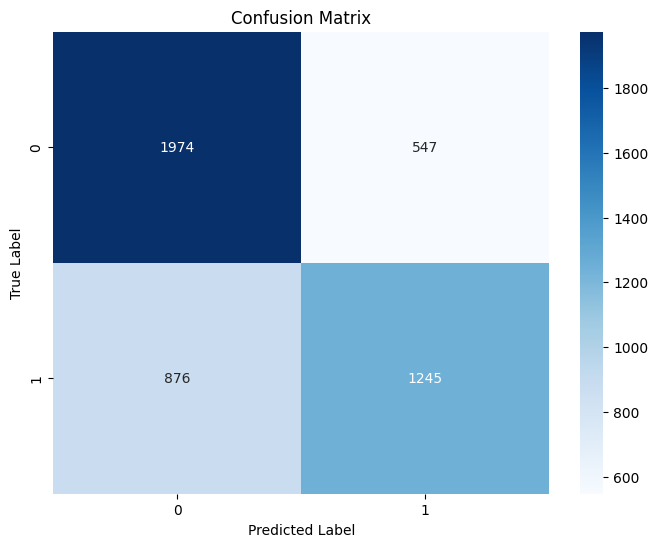

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
labels = best_knn.classes_
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Simpan model KNN
joblib.dump(best_knn, '/content/drive/MyDrive/projek_semester_4/PCD/model_knn_new_1.pkl')

['/content/drive/MyDrive/projek_semester_4/PCD/model_knn_new_1.pkl']

### Random Forest

In [ ]:
# Load data
df = pd.read_csv('/content/drive/MyDrive/projek_semester_4/PCD/data_features/data_gabungan_new.csv')

X = df.drop(columns=['target'])
y = df['target']

# Split data: 80% train, 20% val
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Parameter grid
param_grid = {
    'n_estimators': [100, 200],                   # Jumlah pohon
    'max_depth': [None, 10, 30],                   # Kedalaman maksimum pohon
    'min_samples_split': [2, 5],                   # Minimum sampel untuk split
    'min_samples_leaf': [1, 2],                     # Minimum sampel di setiap daun
    'bootstrap': [True, False]
    }

# Inisialisasi model
rf = RandomForestClassifier(random_state=42)

# Grid search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Tampilkan parameter terbaik
print("Best Parameters:", grid_search.best_params_)
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# Gunakan model terbaik untuk prediksi
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_val)

# Evaluasi model
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

print(f"\nValidation Accuracy: {accuracy_score(y_val, y_pred):.4f}")


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.7090

Confusion Matrix:
[[1879  642]
 [ 684 1437]]

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74      2521
           1       0.69      0.68      0.68      2121

    accuracy                           0.71      4642
   macro avg       0.71      0.71      0.71      4642
weighted avg       0.71      0.71      0.71      4642


Validation Accuracy: 0.7143


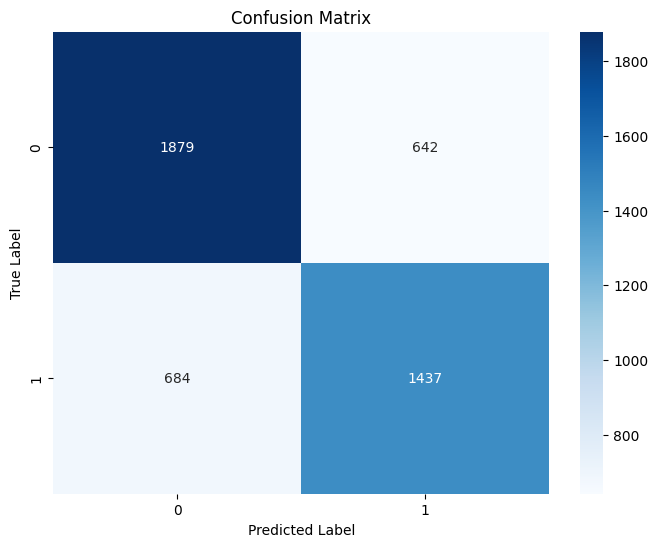

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
labels = best_rf.classes_
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Simpan model
joblib.dump(best_rf, '/content/drive/MyDrive/projek_semester_4/PCD/model_rf.pkl')

['/content/drive/MyDrive/projek_semester_4/PCD/model_rf.pkl']

## Testing

In [5]:
import cv2
import numpy as np

def testing(img1_path, img2_path):
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    # 1. grayscale
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # 2. Gaussian Blur
    blur1 = cv2.GaussianBlur(gray1, (3, 3), 0)
    blur2 = cv2.GaussianBlur(gray2, (3, 3), 0)

    # 4. Otsu Thresholding
    _, otsu1 = cv2.threshold(blur1, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    _, otsu2 = cv2.threshold(blur2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 5. Morphology
    kernel = np.ones((3, 3), np.uint8)
    close1 = cv2.morphologyEx(otsu1, cv2.MORPH_CLOSE, kernel)
    close2 = cv2.morphologyEx(otsu2, cv2.MORPH_CLOSE, kernel)

    # 6. Resize
    resized1 = cv2.resize(close1, (497, 126))
    resized2 = cv2.resize(close2, (497, 126))

    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(resized1, None)
    kp2, des2 = sift.detectAndCompute(resized2, None)

    if des1 is None or des2 is None:
        return [0, 9999, 0]

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)

    jumlah_match = len(good)
    rata_jarak = np.mean([m.distance for m in good]) if good else 9999
    std_jarak = np.std([m.distance for m in good]) if good else 0
    median_jarak = np.median([m.distance for m in good]) if good else 9999
    rasio = jumlah_match / min(len(des1), len(des2))
    rasio_kp1 = jumlah_match / len(des1)
    rasio_kp2 = jumlah_match / len(des2)
    jumlah_kp1 = len(kp1)
    jumlah_kp2 = len(kp2)
    total_match = len(matches)

    return [jumlah_match, rata_jarak, rasio, std_jarak, median_jarak, rasio_kp1, rasio_kp2, jumlah_kp1, jumlah_kp2, total_match]

In [ ]:
dataset_test.head(10)

,gambar1,gambar2,target
0,068/09_068.png,068_forg/03_0113068.PNG,1
1,068/09_068.png,068_forg/01_0124068.PNG,1
2,068/09_068.png,068_forg/02_0124068.PNG,1
3,068/09_068.png,068_forg/01_0113068.PNG,1
4,068/09_068.png,068_forg/04_0124068.PNG,1
5,068/09_068.png,068_forg/04_0113068.PNG,1
6,068/09_068.png,068_forg/02_0113068.PNG,1
7,068/09_068.png,068_forg/03_0124068.PNG,1
8,068/02_068.png,068_forg/03_0113068.PNG,1
9,068/02_068.png,068_forg/01_0124068.PNG,1


In [ ]:
dataset_test.tail(100)

,gambar1,gambar2,target
5648,066/04_066.png,066/01_066.png,0
5649,066/07_066.png,066/10_066.png,0
5650,066/07_066.png,066/03_066.png,0
5651,066/07_066.png,066/04_066.png,0
5652,066/07_066.png,066/09_066.png,0
...,...,...,...
5743,066/01_066.png,066/06_066.png,0
5744,066/01_066.png,066/08_066.png,0
5745,066/01_066.png,066/02_066.png,0
5746,066/01_066.png,066/05_066.png,0


In [15]:
import cv2
import matplotlib.pyplot as plt

def tampilkan_dua_gambar(img1_path, img2_path, ukuran=(497, 126), judul1='Gambar 1', judul2='Gambar 2'):
    # Baca gambar
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    # Resize
    img1 = cv2.resize(img1, ukuran)
    img2 = cv2.resize(img2, ukuran)

    # Konversi BGR ke RGB
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    # latar belakang hitam dan teks putih
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    fig.patch.set_facecolor('black')

    axs[0].imshow(img1)
    axs[0].set_title(judul1, color='white')
    axs[0].axis('off')
    axs[0].set_facecolor('black')
    axs[1].imshow(img2)
    axs[1].set_title(judul2, color='white')
    axs[1].axis('off')
    axs[1].set_facecolor('black')

    plt.tight_layout()
    plt.show()

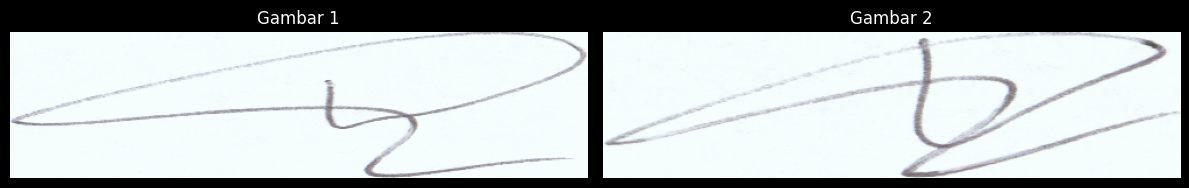

                                                                          Matched


In [14]:
# Load model
model = joblib.load('/content/drive/MyDrive/projek_semester_4/PCD/model_knn_new.pkl')

img1_path = "/content/drive/MyDrive/projek_semester_4/PCD/sign_data/test/066/04_066.png"
img2_path = "/content/drive/MyDrive/projek_semester_4/PCD/sign_data/test/066/02_066.png"

tampilkan_dua_gambar(img1_path, img2_path)

hasil = testing(img1_path, img2_path)
hasil = model.predict([hasil])[0]
print(71*" "+"Not Matched" if hasil == 1 else 74*" "+"Matched")